### Inferring behaviour from text-message data

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this?

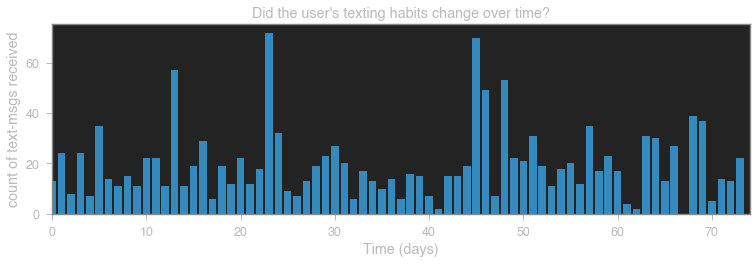

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12.5, 3.5)

count_data = np.loadtxt('../data/txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color='#348ABD')
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of *count* data. Denoting day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as variables.

In [3]:
import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0 / count_data.mean()
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data - 1)

In [4]:
with model:
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

The `switch()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on.

In [5]:
with model:
    observed = pm.Poisson('obs', lambda_, observed=count_data)

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword.

In [6]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10_000, tune=5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:16<00:00, 1855.91draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [8]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

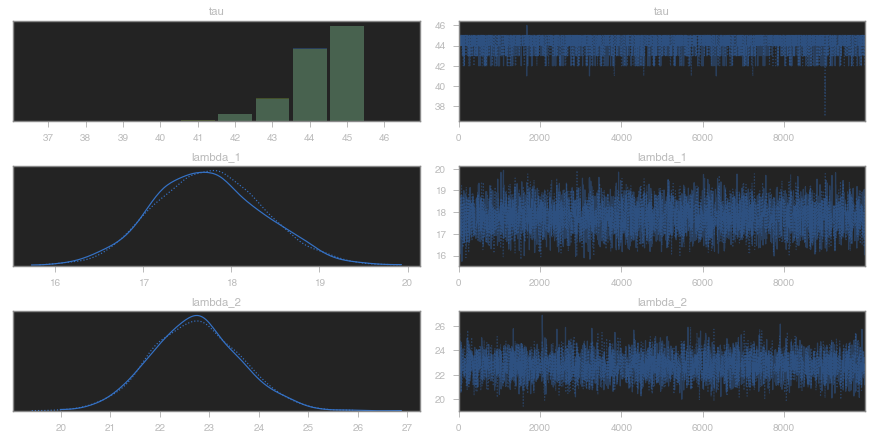

In [7]:
pm.traceplot(trace);

### Interpretation

We now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

If you look at the original data again, do these results seem reasonable?

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points. 

### Why would I want samples from the posterior, anyways?

We'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ at time $t$*?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 

In [11]:
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

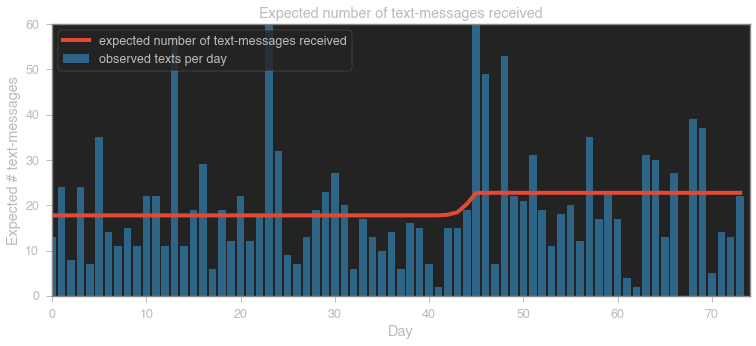

In [13]:
figsize(12.5, 5)
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

Our analysis shows strong support for believing the user's behavior did change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution).

###### Determining Statistically if the Two λs Are Indeed Different?

In [15]:
lambda_1_samples < lambda_2_samples

array([ True,  True,  True, ...,  True,  True,  True])

In [16]:
# how often does this happen?
(lambda_1_samples < lambda_2_samples).sum()

20000

In [17]:
# how many samples are there?
lambda_1_samples.shape[0]

20000

In [18]:
# the ratio is the probability
(lambda_1_samples < lambda_2_samples).mean()

1.0

###### What is the probability that the values differ by at least 1? 2? 5? 10?

In [22]:
for d in [1, 2, 5, 10]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print(f'What is the probability the difference is larger than {d}? {v:.2f}')

What is the probability the difference is larger than 1? 1.00
What is the probability the difference is larger than 2? 1.00
What is the probability the difference is larger than 5? 0.49
What is the probability the difference is larger than 10? 0.00


###### What is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [23]:
print(f'λ_1 mean of the posterior distribution: {lambda_1_samples.mean():.2f}')
print(f'λ_2 mean of the posterior distribution: {lambda_2_samples.mean():.2f}')

λ_1 mean of the posterior distribution: 17.75
λ_2 mean of the posterior distribution: 22.73


###### What is the expected percentage increase in text-message rates?

In [37]:
relative_increase_samples = ((lambda_2_samples - lambda_1_samples) / 
                             lambda_1_samples)
print(f'{relative_increase_samples.mean() * 100:.2f}%')

28.21%


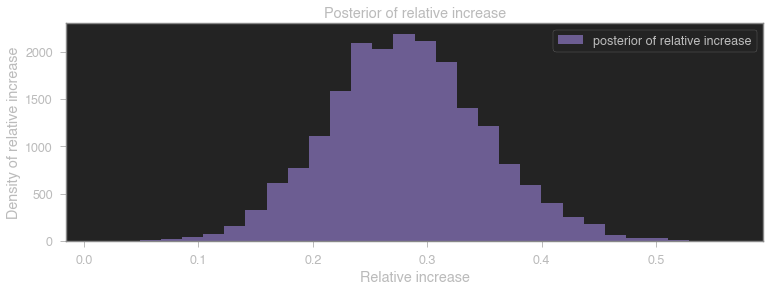

In [38]:
figsize(12.5,4)
plt.hist(
    relative_increase_samples, histtype='stepfilled', bins=30, alpha=0.85, 
    color="#7A68A6", label='posterior of relative increase') 
plt.xlabel("Relative increase")
plt.ylabel("Density of relative increase") 
plt.title("Posterior of relative increase") 
plt.legend();

###### What is the mean of $\lambda_1$ **given** that we know $\tau$ is less than 45.  That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now?

In [41]:
ix = tau_samples < 45
print(f'{lambda_1_samples[ix].mean():.2f}')

17.75
